# Import Library and Helper Functions

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import re
import warnings
from collections import Counter
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import helper as hp

In [5]:
def get_df(root: str) -> dict:
    dfs = {}
    dfs_name=[]
    dfs_shape=[]
    for file in os.listdir(root):
        name = file.split(".")[0]
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            dfs[name] = pd.read_csv(
                join(root, file), encoding="unicode_escape", index_col=0
            )
        dfs_name.append(name)
        dfs_shape.append(dfs[name].shape)
    print(pd.DataFrame(list(zip(dfs_name, dfs_shape)), 
                       columns =['Name', 'Shape']).to_string(index=False))
    return dfs

In [6]:
def insert_and_sort_imp(df:pd.DataFrame, df_feat: pd.DataFrame) -> pd.DataFrame:
    df["Importance"] = None
    for idx, row in df.Row.iteritems():
        if row in df_feat_imp.index:
            df["Importance"][idx] = df_feat.importance[
                df_feat.index == row
            ].values[0]
    return df.sort_values(by='Importance', ascending=False)

In [7]:
def get_feature_desc(
    df_feat: pd.DataFrame, df_desc: pd.DataFrame, script: str
) -> pd.DataFrame:
    df_1 = df_desc[["Table", "Row", "Description"]][df_desc.Row.isin(df_feat.index)]
    rest = list(set(df_feat.index) - set(df_1.Row))
    if len(rest) > 0:
        Row = []
        Description = []
        for feat in rest:
            with open(script, "r") as f:
                for line in f:
                    if feat in line:
                        Row.append(feat)
                        Description.append(re.sub("[df\n\[\]]", "", line.split("= ")[-1]))
        df_2 = pd.DataFrame(list(zip(Row, Description)), columns=["Row", "Description"])
        rest_2 = list(set(rest) - set(df_2.Row))
        if len(rest_2) > 0:
            Table = []
            Row = []
            Description = []
            for feat_long in rest_2:
                agg = feat.rsplit("_", 1)[1]
                feat = feat_long.rsplit("_", 1)[0]
                feat_short = feat.split("_", 1)[-1]
                if feat_short in df_desc.Row.unique():
                    Table.append(df_desc.Table[df_desc.Row == feat_short].values[0])
                    Row.append(feat_long)
                    Description.append(
                        df_desc.Description[df_desc.Row == feat_short].values[0]
                    )
            df_3 = pd.DataFrame(
                list(zip(Table, Row, Description)),
                columns=["Table", "Row", "Description"],
            )

            return insert_and_sort_imp(
                pd.concat([df_1, df_2, df_3]).reset_index(drop=True), df_feat
            )
        return insert_and_sort_imp(
            pd.concat([df_1, df_2]).reset_index(drop=True), df_feat
        )
    return insert_and_sort_imp(df_1.reset_index(drop=True), df_feat)

# Import Raw Data

In [9]:
%%time
dfs = get_df(root="data_raw")

                           Name          Shape
 HomeCredit_columns_description       (219, 4)
               POS_CASH_balance  (10001358, 7)
               application_test   (48744, 120)
              application_train  (307511, 121)
                         bureau  (1716428, 16)
                 bureau_balance  (27299925, 2)
            credit_card_balance  (3840312, 22)
          installments_payments  (13605401, 7)
           previous_application  (1670214, 36)
              sample_submission     (48744, 1)
CPU times: user 1min 22s, sys: 1min 58s, total: 3min 21s
Wall time: 3min 21s


In [9]:
# Number of unique columns in all of the datasets
dfs['HomeCredit_columns_description'].Row.nunique()

196

# Import Merged DataFrame and Feature Importance

In [9]:
%%time
# import merged dataframe
df_combined = pd.read_csv('data/combined.csv', index_col=0)
print(df_combined.shape) 
# import top 20 important features
df_feat_imp = pd.read_csv('data/feat_importance.csv', index_col=0)
print(df_feat_imp.shape)

(356251, 797)
(795, 1)
CPU times: user 56.2 s, sys: 12.3 s, total: 1min 8s
Wall time: 1min 8s


In [7]:
df_combined.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# display top 20 features
df_feat_imp_200 = df_feat_imp[:200]
df_feat_imp_20 = df_feat_imp[:20]
df_feat_imp_20

,importance
feature,
PAYMENT_RATE,1078.6
EXT_SOURCE_1,974.6
EXT_SOURCE_3,883.4
EXT_SOURCE_2,817.2
DAYS_BIRTH,645.0
DAYS_EMPLOYED,468.2
AMT_ANNUITY,461.4
APPROVED_CNT_PAYMENT_MEAN,370.7
INSTAL_DPD_MEAN,343.7


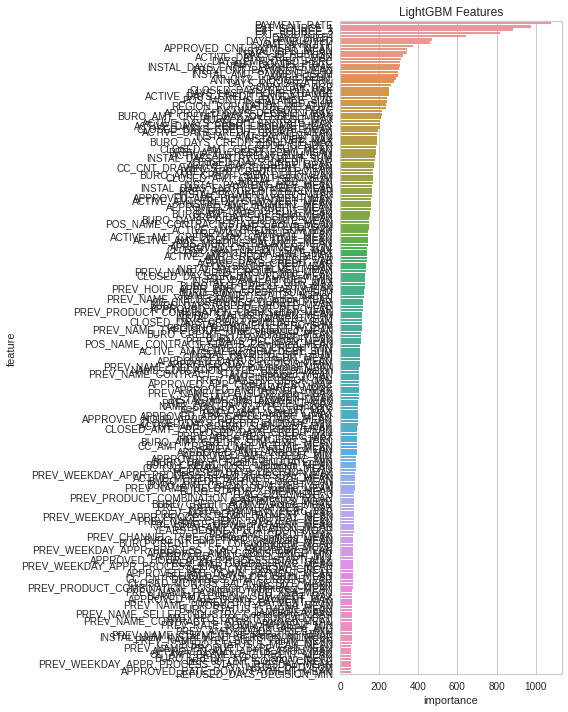

CPU times: user 7.57 s, sys: 822 ms, total: 8.39 s
Wall time: 7.58 s


In [12]:
%%time
# plot bar chart for top 200 important features
plt.figure(figsize=(8, 10))
sns.barplot(
    x=df_feat_imp_200.importance,
    y=df_feat_imp_200.index,
)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

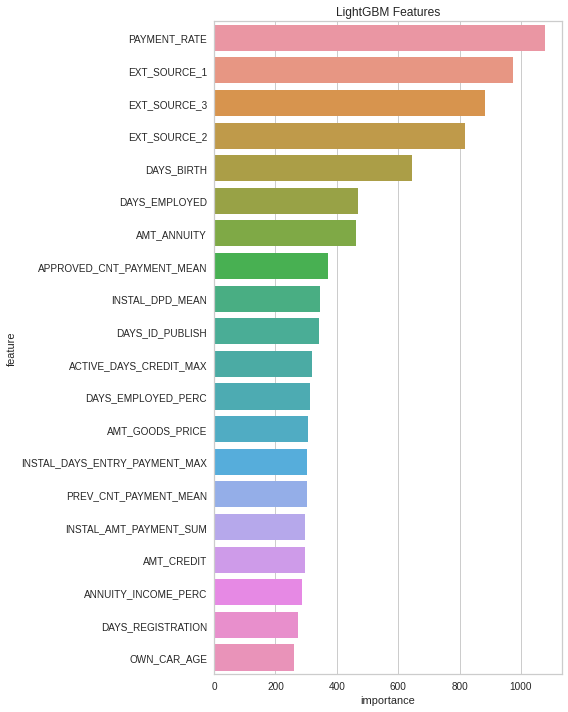

CPU times: user 626 ms, sys: 194 ms, total: 820 ms
Wall time: 614 ms


In [13]:
%%time
# plot bar chart for top 20 important features
length=20
plt.figure(figsize=(8, 10))
sns.barplot(
    x=df_feat_imp_20.importance,
    y=df_feat_imp_20.index,
)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [11]:
# get feature descriptions
df_explain = get_feature_desc(
    df_feat_imp_200,
    dfs["HomeCredit_columns_description"],
    script="lightgbm_with_simple_features.py",
)
# display top 20 features' descriptions
with pd.option_context('display.max_colwidth', 150):
    display(df_explain[['Table', 'Row', 'Description']].head(20))

,Table,Row,Description
33,NaN,PAYMENT_RATE,'AMT_ANNUITY' / 'AMT_CREDIT'
13,application_{train|test}.csv,EXT_SOURCE_1,Normalized score from external data source
15,application_{train|test}.csv,EXT_SOURCE_3,Normalized score from external data source
14,application_{train|test}.csv,EXT_SOURCE_2,Normalized score from external data source
6,application_{train|test}.csv,DAYS_BIRTH,Client's age in days at the time of application
7,application_{train|test}.csv,DAYS_EMPLOYED,How many days before the application the person started current employment
28,previous_application.csv,AMT_ANNUITY,Annuity of previous application
27,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit
3,application_{train|test}.csv,AMT_ANNUITY,Loan annuity
94,previous_application.csv,APPROVED_CNT_PAYMENT_MEAN,Term of previous credit at application of the previous application


# Analyse de Données

In [11]:
# investigate the top 20 important features
df_feat_imp_20_list = df_feat_imp_20.index.to_list()
# PLUS 'TARGET'
df_feat_imp_20_list.append('TARGET')
df_combined_20 = df_combined[df_feat_imp_20_list]
df_combined_20 = df_combined_20[~df_combined_20["TARGET"].isnull()]

In [12]:
# keep records that's TARGET value is not null
TARGET = df_combined["TARGET"][~df_combined["TARGET"].isnull()]

## Variables Quantitatives

### Analyse Univariée

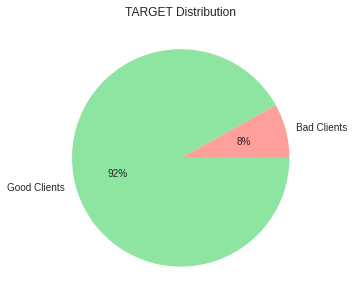

CPU times: user 240 ms, sys: 19 ms, total: 259 ms
Wall time: 261 ms


In [27]:
%%time
# define seaborn color palette to use
colors = sns.color_palette("pastel")[2:4][::-1]

# count 'TARGET' and set labels
counts = Counter(TARGET)
labels = ['Bad Clients', 'Good Clients']

# create pie chart
plt.figure(figsize=(5,5))
plt.pie(counts.values(), labels=labels, colors=colors, autopct="%.0f%%")
plt.title("TARGET Distribution")
plt.show()

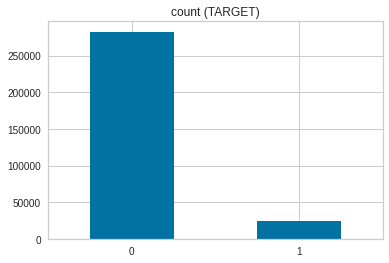

In [26]:
# create histogram
TARGET.value_counts().plot(kind="bar", title="count (TARGET)", xticks=[0, 1])
plt.xticks(rotation=0)
plt.show()

Number of quantitaive columns: 21


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


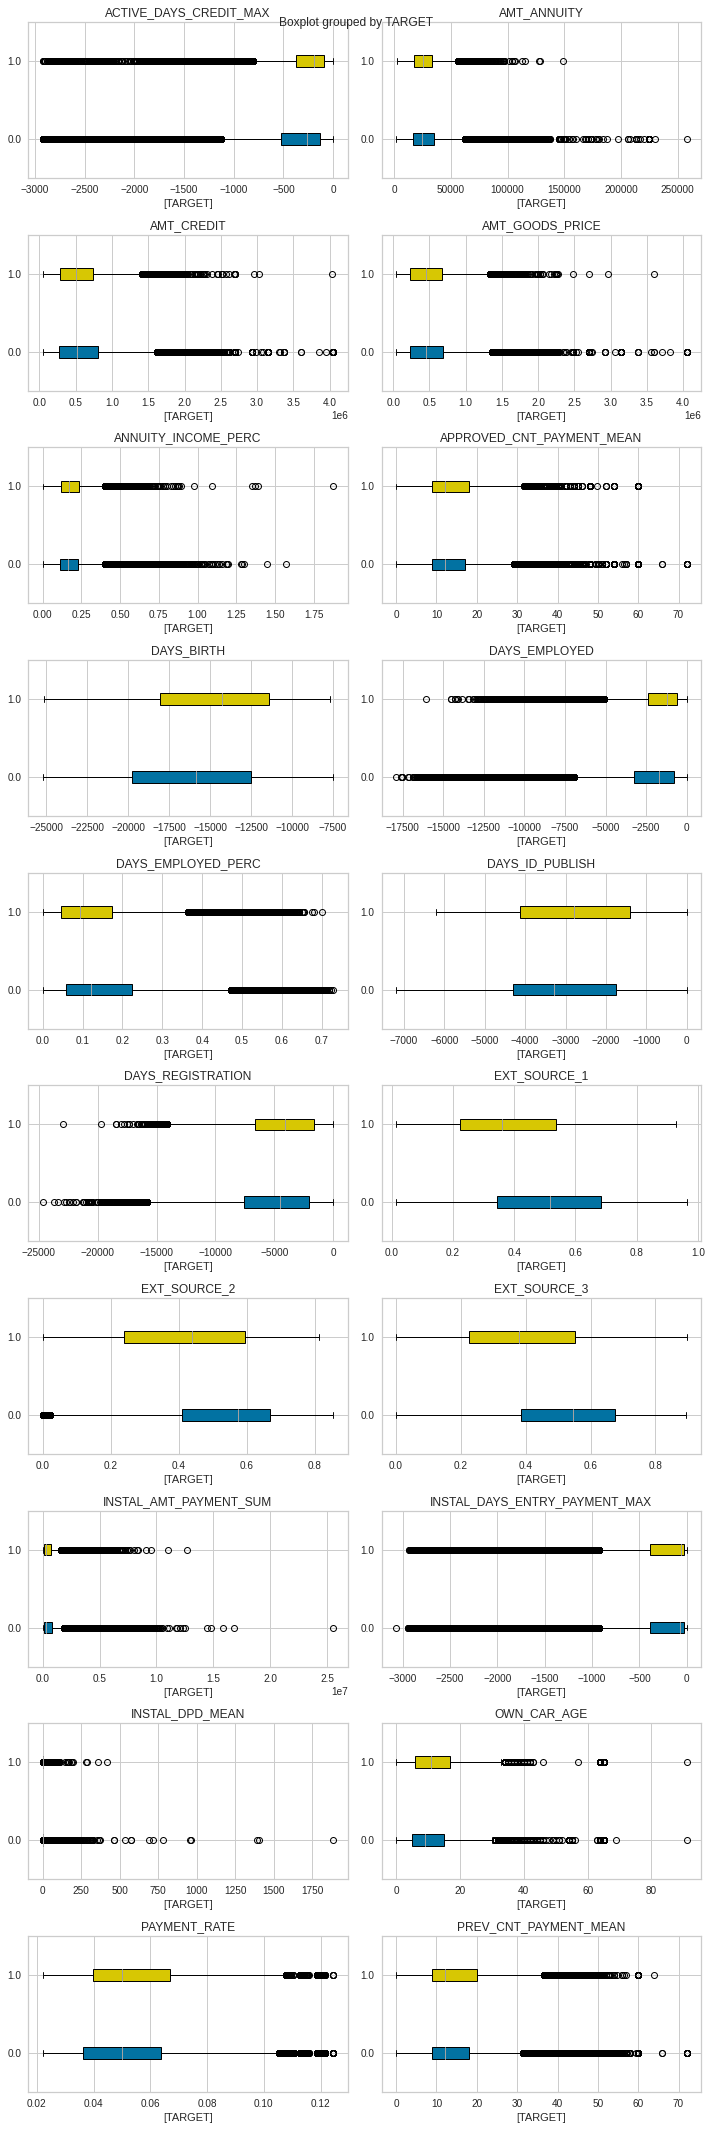

CPU times: user 4.27 s, sys: 223 ms, total: 4.49 s
Wall time: 4.23 s


In [21]:
%%time
# plot boxplot for quantitative variables
hp.plot_boxplots(df_combined_20, sub_col=2, figsize=(10, 30), groupby_class="TARGET")

Number of quantitaive columns: 21


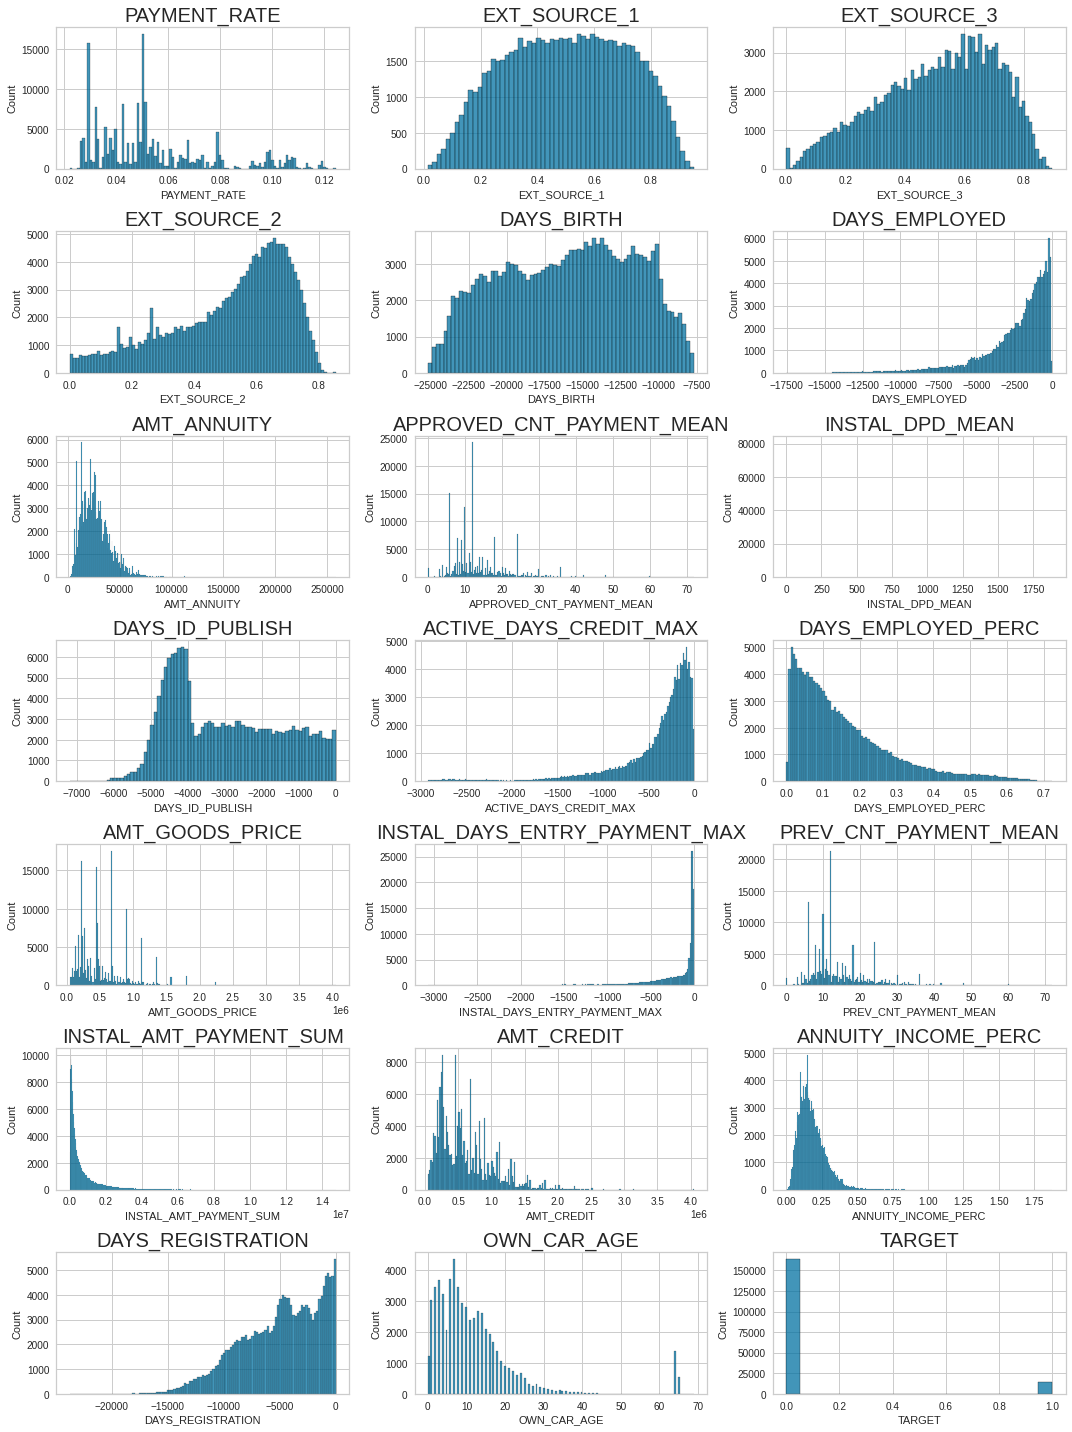

CPU times: user 3min 44s, sys: 0 ns, total: 3min 44s
Wall time: 3min 44s


In [25]:
%%time
# plot histogram for quantitative variables
hp.plot_histplots(df_combined_20, figsize=(15, 20),div=2)

### Analyse Multivariée

#### Correlation

In [26]:
%%time
# plot heamap
hp.heatmap(df_combined_20, figsize=(100, 100), scale=9.5)

Number of quantitaive columns: 21


CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.7 s
